# DESAFÍO N° 2 - MODELADO

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score

In [21]:
data = pd.read_csv("salida_desafio_1.csv")
data.sample(5)

,Unnamed: 0,tipo_prop,barrio,pais,lat,lon,precio_usd,piso,properati_url,ambientes,...,villa_crespo,hidromasaje,san_telmo,vista,sauna,losa_radiante,capital_federal,impecable,interwin,doble_circulacion
27865,27865,apartment,Recoleta,Argentina,-34.588700,-58.397230,118000.00,1.0,http://www.properati.com.ar/1bvv4_venta_depart...,NaN,...,0,0,0,0,0,0,0,0,0,0
15991,15991,apartment,Villa Urquiza,Argentina,-34.570884,-58.488694,212900.00,0.0,http://www.properati.com.ar/19z8g_venta_depart...,3.0,...,0,0,0,0,0,0,0,0,0,0
19637,19637,apartment,Belgrano,Argentina,-34.562700,-58.458290,153302.87,NaN,http://www.properati.com.ar/1ao05_venta_depart...,2.0,...,0,0,0,0,0,0,0,0,0,0
17402,17402,store,Recoleta,Argentina,-34.592609,-58.401407,1450000.00,11.0,http://www.properati.com.ar/1abla_venta_local_...,1.0,...,0,0,0,0,0,0,0,0,1,0
905,905,apartment,Palermo Soho,Argentina,-34.588560,-58.430530,218000.00,NaN,http://www.properati.com.ar/15q8u_venta_depart...,2.0,...,0,0,0,0,0,0,0,0,0,0


## Reducción de volumen de datos

Decidimos elegir como dataset de trabajo los barrios dentro de la Comuna 13: Belgrano, Nuñez y Colegiales

Esta decisión la tomamos ya que es una de las comunas con mayor desarrollo inmobiliario en la CABA. Vamos a trabajar con 4122 datos de tres barrios porteños.

In [22]:
data2 = data[(data.barrio == "Belgrano") | (data.barrio == "Colegiales") | (data.barrio == "Nuñez")]
data2.shape

(4122, 57)

## Preparación del DATASET

In [23]:
data2.sample(10)
data2.columns

data2.drop(['Unnamed: 0', 'pais', 'lat', 'lon', 'precio_usd', 'villa_urquiza', 'barrio_norte', 'villa_crespo', 'lujoso', 'san_telmo',
          'capital_federal', 'impecable', 'interwin', 'properati_url', 'properati_url_clean'], axis = 1, inplace = True)

C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
data2['piso'] = data2.piso.apply(lambda x: np.NaN if x > 30 else x)
data2['ambientes'] = data2.ambientes.apply(lambda x: np.NaN if x > 6 else x)

C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
a = data2[data2.tipo_prop == "apartment"].piso.fillna(int(data2.piso.mode()))
b = data2[data2.tipo_prop != "apartment"].piso.fillna(0)

piso = a.append(b)

data2['piso'] = data2.piso.fillna(piso)

data2.ambientes.fillna(int(data2.ambientes.mode()), inplace = True)

data2.isnull().sum()

data2 = data2[data2.sup_total.notnull()]

data = data2[data2.precio_x_m2_usd.notnull()]

C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


## Modelado

#### Preparación de dummies y categoricas

In [26]:
a = pd.get_dummies(data[['tipo_prop', 'barrio']])
a.drop(['tipo_prop_apartment', 'barrio_Belgrano'], inplace= True, axis = 1)

data = pd.merge(data, a, left_index= True, right_index= True)

In [27]:
data.drop(['barrio', 'tipo_prop'], axis = 1, inplace= True)

In [28]:
data = data[data.precio_x_m2_usd <= 15000]

Separamos el dataset en un segmento de entrenameinto y otro de testeo

In [29]:
X = data.drop('precio_x_m2_usd', axis = 1)
y = data.precio_x_m2_usd

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True)

In [30]:
print(X_train.shape)
print(X_test.shape)

(2694, 44)
(898, 44)


In [31]:
X.columns

Index(['piso', 'ambientes', 'sup_total', 'sup_cubierta', 'subtes', 'bicis',
       'comisarias', 'balcon', 'garage', 'lavadero', 'luminoso',
       'subte_linea_d', 'parrilla', 'subte_linea_b', 'aire_acondicionado',
       'piscina', 'subte_linea_a', 'terraza', 'placard', 'toilette', 'suite',
       'subte_linea_h', 'sum', 'amenities', 'subte_linea_e', 'baulera',
       'gimnasio', 'patio', 'subte_linea_c', 'dependencias', 'vestidor',
       'estrenar', 'apto_credito_hipotecario', 'jardin', 'hidromasaje',
       'vista', 'sauna', 'losa_radiante', 'doble_circulacion', 'tipo_prop_PH',
       'tipo_prop_house', 'tipo_prop_store', 'barrio_Colegiales',
       'barrio_Nuñez'],
      dtype='object')

<AxesSubplot:xlabel='sup_total', ylabel='precio_x_m2_usd'>

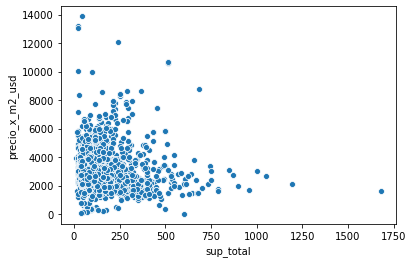

In [32]:
sns.scatterplot(y = y, x = X.sup_total)

### Regresión Lineal Multiple

0.057828473156324445


[(0.0, 7500.0), (0.0, 7500.0)]

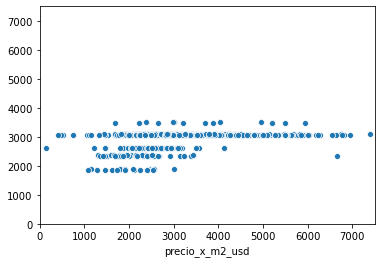

In [19]:
model_lrm = LinearRegression()

model_lrm.fit(X_train[['barrio_Colegiales', 'barrio_Nuñez', 'tipo_prop_house', 'tipo_prop_store', 'tipo_prop_PH']], y_train)

y_predict = model_lrm.predict(X_test[['barrio_Colegiales', 'barrio_Nuñez', 'tipo_prop_house', 'tipo_prop_store', 'tipo_prop_PH']])

print(r2_score(y_test, y_predict))

b = sns.scatterplot(x = y_test, y = y_predict)
b.set(xlim=(0,7500), ylim = (0, 7500))

-0.0035221579440558592


[(0.0, 7500.0), (0.0, 7500.0)]

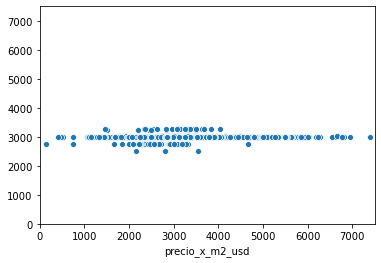

In [20]:
model_lrm2 = LinearRegression()

model_lrm2.fit(X_train[['balcon', 'garage', 'lavadero', 'jardin']], y_train)

y_predict = model_lrm2.predict(X_test[['balcon', 'garage', 'lavadero', 'jardin']])

print(r2_score(y_test, y_predict))

b = sns.scatterplot(x = y_test, y = y_predict)
b.set(xlim=(0,7500), ylim = (0, 7500))

<bound method RegressorMixin.score of LinearRegression()>
0.0737505715392549


[(0.0, 7500.0), (0.0, 7500.0)]

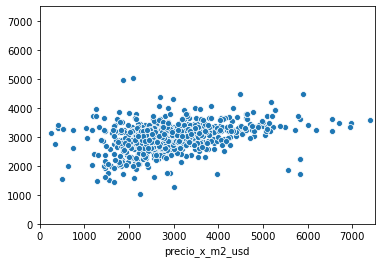

In [33]:
model_lrm = LinearRegression()

model_lrm.fit(X_train, y_train)
print(model_lrm.score)

y_predict = model_lrm.predict(X_test)

print(r2_score(y_test, y_predict))

b = sns.scatterplot(x = y_test, y = y_predict)
b.set(xlim=(0,7500), ylim = (0, 7500))

## LASSO

In [37]:
X = data.drop('precio_x_m2_usd', axis = 1)
y = data.precio_x_m2_usd

std = StandardScaler()
X_std = X[['piso', 'ambientes', 'sup_total', 'sup_cubierta', 'subtes', 'bicis', 'comisarias']]
X_std = std.fit_transform(X_std)

X[['piso', 'ambientes', 'sup_total', 'sup_cubierta', 'subtes', 'bicis', 'comisarias']] = X_std

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True)

In [47]:
model_lasso = LassoCV(cv = 3)


model_lasso.fit(X_train, y_train)
y_predict = model_lasso.predict(X_test)

print("El score obtenido en el dataset de training fue de:", r2_score(y_train, model_lasso.predict(X_train)))
print("El score obtenido en el dataset de testing fue de:", r2_score(y_test, y_predict))
print()
coeficientes = list(model_lasso.coef_)
nombre = list(X.columns)

coef = pd.DataFrame(coeficientes, index = nombre)
coef

El score obtenido en el dataset de training fue de: 0.12961280290681587
El score obtenido en el dataset de testing fue de: 0.12618456699384828



,0
piso,-38.779627
ambientes,31.736441
sup_total,-385.845679
sup_cubierta,483.667709
subtes,-4.443090
bicis,-17.862500
comisarias,-56.793178
balcon,-219.258516
garage,0.000000
lavadero,-85.627183
